In [52]:
import numpy as np
import pickle
import torch
from torch_geometric.data import Batch
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
import torch
import torch.nn.functional as F
from torch_geometric.nn import GatedGraphConv, AttentionalAggregation
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from tqdm import tqdm
from copy import deepcopy
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [53]:
class GCN(torch.nn.Module):
    def __init__(self, num_hidden, num_gated_layers, num_lin_layers, dropout):
        super(GCN, self).__init__()
        
        self.num_lin_layers = num_lin_layers
        self.dropout = dropout

        # Gated Graph convolution
        self.gated_conv = GatedGraphConv(out_channels=num_hidden, num_layers=num_gated_layers) 

        self.att = AttentionalAggregation(torch.nn.Linear(num_hidden, 1))

        # Define the GCN layers
        self.lin = torch.nn.ModuleList()
        for _ in range(num_lin_layers - 1):
            self.lin.append(torch.nn.Linear(num_hidden, num_hidden))
        self.lin.append(torch.nn.Linear(num_hidden, 1))

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Pass input through gated convolution
        x = self.gated_conv(x, edge_index)

        # Attentional Aggregation
        x = self.att(x, batch)

        # Pass the input through the GCN layers
        for i in range(self.num_lin_layers - 1):
            x = self.lin[i](x)
            x = F.relu(x)
            x = F.dropout(x, training=self.training, p=self.dropout)
   
        # Pass through the final layer
        x = self.lin[-1](x)
        
        return x
    
    def load_state(self,name):
        self.load_state_dict(torch.load(name))



In [54]:
import numpy as np
import iteround
import itertools as it
from copy import copy, deepcopy
import torch
from ase.build import fcc111, add_adsorbate
from ase.neighborlist import NeighborList,natural_cutoffs
from torch_geometric.data import Data, Batch


metals = ['Ag', 'Au', 'Cu', 'Pd', 'Pt', 'Zn']
adsorbates = ['OCH3', 'MC', 'CO', 'OH']
N = '2'

regressor = GCN(24,3,1,0.5)
regressor.load_state(f'N{N}/best_model_ALL_{N}.pth')


class Surface_DMC():
    def __init__(self,incl_graph_features=['layer','aoi'],n=200,n_layers=3) -> None:
        self.metals = metals
        self.n = n
        self.n_layers = n_layers
        self.size = (self.n,self.n)
        self.top_zones = [[0,1,2],[0,1,2],[0,1],[],[]]
        self.adsorbates = adsorbates
        self.ads_site = {ads:'ontop' for ads in adsorbates}
        self.regressor = regressor


        self.incl_graph_features = incl_graph_features
        self.get_graph_features_and_edges()
            


    def initiate_surface(self,f):
    
        #Number of atoms in surface
        n_surface_atoms = np.prod(self.size)
        #Total number of atoms
        n_atoms = n_surface_atoms*self.n_layers
        #number of each metal
        n_each_metal = f*n_atoms
        #Round to integer values while maintaining sum
        n_each_metal=iteround.saferound(n_each_metal, 0)
        
        assert(np.sum(n_each_metal)==n_atoms)

        #Make list of metals
        symbols=[]
        for i in range(len(self.metals)):
            symbols+=[self.metals[i]] * int(n_each_metal[i])
    
        #Shuffle the elements
        np.random.shuffle(symbols)
        
        #Make 3D grid as surface
        self.surface = np.reshape(symbols,(*self.size,self.n_layers))
        

    def get_site(self,grid,coords):

        site = np.array([(0,0,0)])

        top_1a = np.array([(1,0,0),(0,1,0),(-1,1,0),(-1,0,0),(0,-1,0),(1,-1,0)])
        top_1b = np.array([(1,1,0),(-1,2,0),(-2,1,0),(-1,-1,0),(1,-2,0),(2,-1,0)])
        top_1c = np.array([(2,0,0),(0,2,0),(-2,2,0),(-2,0,0),(0,-2,0),(2,-2,0)])
        zones_1 = [top_1a,top_1b,top_1c]

        top_2a = np.array([(0,0,1),(0,-1,1),(1,-1,1)])
        top_2b = np.array([(1,0,1),(-1,0,1),(1,-2,1)])
        top_2c = np.array([(0,1,1),(-1,1,1),(-1,-1,1),(0,-2,1),(2,-1,1),(2,-2,1)])
        zones_2 = [top_2a,top_2b,top_2c]
        
        top_3a = np.array([(0,0,2),(-1,0,2),(0,-1,2)])
        top_3b = np.array([(-1,1,2),(-1,-1,2),(1,-1,2)])
        top_3c = np.array([(1,0,2),(0,1,2),(-2,1,2),(-2,0,2),(0,-2,2),(1,-2,2)])
        zones_3 = [top_3a,top_3b,top_3c]

        top_4a = np.array([(0,0,3)])
        top_4b = np.array([(1,0,3),(0,1,3),(-1,1,3),(-1,0,3),(0,-1,3),(1,-1,3)])
        top_4c = np.array([(1,1,3),(-1,2,3),(-2,1,3),(-1,-1,3),(1,-2,3),(2,-1,3)])
        top_4d = np.array([(2,0,3),(0,2,3),(-2,2,3),(-2,0,3),(0,-2,3),(2,-2,3)])
        zones_4 = [top_4a,top_4b,top_4c,top_4d]

        top_5a = np.array([(0,0,4),(0,-1,4),(1,-1,4)])
        top_5b = np.array([(1,0,4),(-1,0,4),(1,-2,4)])
        top_5c = np.array([(0,1,4),(-1,1,4),(-1,-1,4),(0,-2,4),(2,-1,4),(2,-2,4)])
        zones_5 = [top_5a,top_5b,top_5c]

        zones = [site]  
        zones += [zones_1[i] for i in self.top_zones[0]]
        zones += [zones_2[i] for i in self.top_zones[1]]
        zones += [zones_3[i] for i in self.top_zones[2]]
        zones += [zones_4[i] for i in self.top_zones[3]]
        zones += [zones_5[i] for i in self.top_zones[4]]

        return [grid[tuple(((zone + coords) % grid.shape).T)] for zone in zones]


    
    
    def get_edges(self,atoms,add_node_dist_feature=False,ads_idx=0):
        
        cutoff = natural_cutoffs(atoms, mult=1.0)
        nl = NeighborList(cutoff, self_interaction=False, bothways=True)
        # Update the neighbor list with the atom positions
        nl.update(atoms)

        # Make adjencency from neighborlist
        adj_matrix = nl.get_connectivity_matrix(sparse=False)
        # Get the indices of the non-zero elements in the adjacency matrix
        src_idx, tgt_idx = np.nonzero(adj_matrix)

        # Create the edge index numpy array
        edges = np.vstack((src_idx, tgt_idx))

        self.edges = torch.LongTensor(edges)

        if add_node_dist_feature:
            self.graph_features['node_dist'] = self.dijkstra(adj_matrix,ads_idx)
    
    def dijkstra(self,adj_matrix, source):
        """
        Dijkstra's algorithm for an adjacency matrix with 0s and 1s.

        Parameters:
        - adj_matrix: Adjacency matrix with 0s and 1s.
        - source: Source node.

        Returns:
        - distances: Array containing the shortest distances from the source node to all other nodes.
        """

        num_nodes = len(adj_matrix)
        distances = np.full(num_nodes, np.inf)
        distances[source] = 0

        visited = set()

        while len(visited) < num_nodes:
            # Find the unvisited node with the smallest tentative distance
            current_node = min((node for node in range(num_nodes) if node not in visited), key=lambda node: distances[node])

            # Mark the current node as visited
            visited.add(current_node)

            # Update distances to neighbors of the current node
            for neighbor in range(num_nodes):
                if neighbor not in visited and adj_matrix[current_node][neighbor] == 1:
                    new_distance = distances[current_node] + 1  # Unit distance for binary adjacency matrix
                    if new_distance < distances[neighbor]:
                        distances[neighbor] = new_distance

        return np.asarray(distances,dtype=int)
    
    def get_graph_features_and_edges(self):
        
        # make a clean Pt slab for top and fcc site
        slab = fcc111('Pt',(9,9,5),vacuum=10)


        # Make grid of ids
        grid = np.array([atom.index for atom in slab]).reshape(5,9,9)
        grid = grid[[4,3,2,1,0]]
        grid=grid.T
        
        # Add adsorbates in center of slab
        add_adsorbate(slab,'C',height=2,position='ontop',offset=(4,4))

        
        zones = self.get_site(grid,(4,4,0))

        # Insert adsorbate id
        ids = np.insert(np.concatenate(zones),0,len(slab)-1)

        atoms = slab[np.asarray(ids,dtype=int)]

        self.edges = {}
        self.graph_features = {feature:{} for feature in self.incl_graph_features}
            
        if 'layer' in self.incl_graph_features:
            self.graph_features['layer'] = np.array([atom.tag for atom in atoms])

        if 'node_dist' in self.incl_graph_features:
            self.get_edges(atoms,True)
        else:
            self.get_edges(atoms,False)

        if 'aoi' in self.incl_graph_features:
            aoi_zones = {
                'ontop': {'site': [0],
                          0: [[0]*6,[0]*6,[1]*6],           # aoi zone 1c
                          1: [[0]*3,[0]*3,[0]*6],
                          2: [[0]*3,[1]*3,[0]*6],           # aoi zone 3b
                          3: [[0]*1,[0]*6,[0]*6,[0]*6],    
                          4: [[0]*3,[0]*3,[0]*6]
                          },
                'fcc': {'site':[0,0,0],
                        0: [[0]*3,[0]*6,[0]*6,[0]*3,[1]*6], # aoi zone 1e
                        1: [[0]*3,[0]*3,[0]*6,[0]*6],
                        2: [[0]*1,[0]*6,[1]*3,[0]*3],       # aoi zone 3c
                        3: [[0]*3,[0]*3,[0]*6,[0]*6],
                        4: [[0]*3,[0]*3,[0]*6,[0]*6]
                }
            }
            aoi_feature = [0] + aoi_zones['ontop']['site']     # ads + site
            for layer_idx,zones in enumerate(self.top_zones):
                for zone in zones:
                    aoi_feature+= aoi_zones['ontop'][layer_idx][zone]
            
            self.graph_features['aoi'] = aoi_feature

        if 'zones' in self.incl_graph_features:
            zone_feature = np.zeros((len(atoms),len(zones)))
            atom_i = 1
            for i,zone in enumerate(zones):
                zone_feature[atom_i:atom_i+len(zone),i] = 1
                atom_i+=len(zone)
            
            self.graph_features['zones'] = zone_feature

        
    def graph_feature(self,grid_coords,adsorbate):
        
        zones = self.get_site(self.surface,grid_coords)
        labels = np.concatenate(zones,dtype='object')
        labels = np.insert(labels,0,adsorbate)


        elements = self.metals + self.adsorbates
        # onehot encode elements
        features = np.zeros((len(labels),len(elements)))
        for i,elem in enumerate(labels):
            features[i,elements.index(elem)] = 1

        # graph features
        n_graph_features = len(self.graph_features)
        if 'zones' in self.incl_graph_features:
            n_graph_features-=1

        graph_features_ = np.zeros((n_graph_features,len(labels)))
        for i,graph_feature_name in enumerate(self.incl_graph_features):
            if graph_feature_name =='zones':
                graph_features_ = np.vstack((graph_features_,self.graph_features['zones'].T))
            else:
                graph_features_[i] = self.graph_features[graph_feature_name]

        # combine features
        features = np.hstack((features,graph_features_.T))

        # convert to torch tensor
        torch_nodes = torch.tensor(features, dtype=torch.float)
        
        return torch_nodes



    def predict_energies(self):
        #Get shape of surface
        n_rows,n_cols,n_layers = self.surface.shape
        
        #load regressor
        # reg = load(f'trained_models/{adsorbate}.joblib')
        
        #Initiate list to store adsorption energies of each site

        graphs={ads:[] for ads in self.adsorbates}

        site_ids = []
        
        for row in range(n_rows):
            for col in range(n_cols):
                
                #site index
                site_ids.append([row,col])
    
                        
                for ads in self.adsorbates:
                    features = self.graph_feature((row,col,0),ads)

                    graphs[ads].append(Data(x=features, edge_index=self.edges))

 

                
        site_ids = np.array(site_ids)

        energies = []
        for ads in self.adsorbates:
            batch = Batch.from_data_list(graphs[ads])
            energies.append(self.regressor.forward(batch).detach().numpy().flatten())

        
        return *energies, site_ids
    
    print('Done')



Done


In [55]:
surface = Surface_DMC(n=200)

In [56]:
surface.initiate_surface(np.ones(6)/6)
E_OCH3,E_MC,E_CO,E_OH,site_ids = surface.predict_energies()

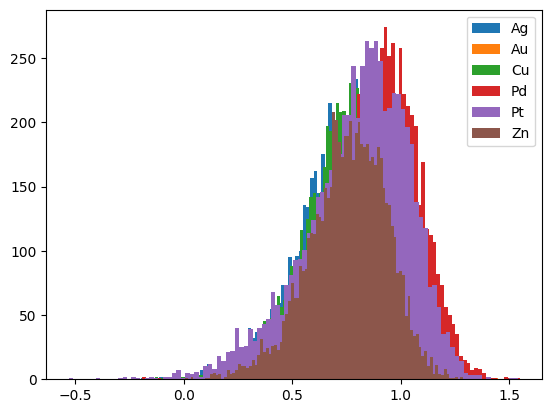

In [30]:
surface_metals = surface.surface[:,:,0].flatten()
for metal in metals:
    mask = surface_metals == metal

    plt.hist(E_OCH3[mask],bins=100,label=metal)
plt.legend()

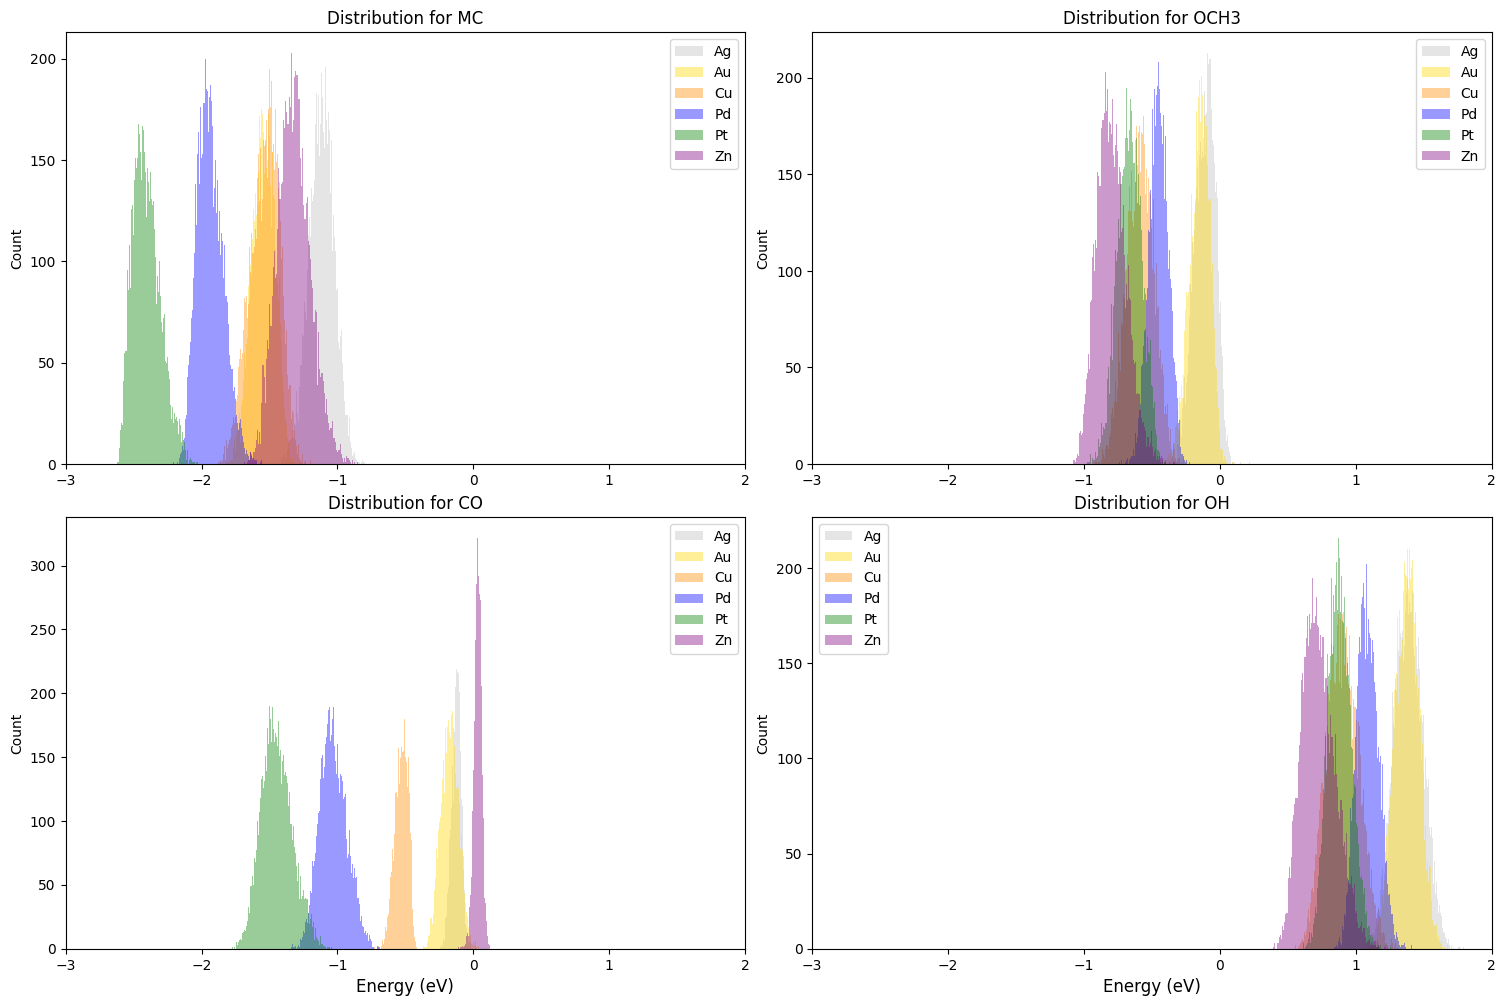

In [61]:
# Get the unique metals in the surface
surface_metals = surface.surface[:, :, 0].flatten()
metals = np.unique(surface_metals)

# Define colors for each metal
metal_colors = {
    'Ag': 'silver', 
    'Au': 'gold', 
    'Cu': 'darkorange', 
    'Pd': 'blue', 
    'Pt': 'green', 
    'Zn': 'purple'
}

# Create figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Define adsorbates and their respective energies
adsorbates = {
    "OH": E_OH,
    "CO": E_CO,
    "OCH3": E_OCH3,
    "MC": E_MC
}

plot_titles = [
    'Distribution for MC',
    'Distribution for OCH3',
    'Distribution for CO',
    'Distribution for OH'
]

# Plot histograms for each adsorbate
for ax, (adsorbate, energies), title in zip(axs.flatten(), adsorbates.items(), plot_titles):
    for metal in metals:
        mask = surface_metals == metal
        color = metal_colors.get(metal, 'black')  # Default to black if the metal is not in the metal_colors dict
        ax.hist(energies[mask], bins=100, alpha=0.4, label=metal, histtype='stepfilled', color=color)
    ax.set_title(title)  # Set the correct title for each plot
    ax.set_ylabel('Count')
    ax.legend()
    ax.set_xlim(-3, 2)  # Centering the x-axis around 0
    ax.set_yticks(np.arange(0, ax.get_ylim()[1]+1, 50))  # Set y-axis tick marks every 50 units


axs[1, 0].set_xlabel('Energy (eV)', fontsize=12)
axs[1, 1].set_xlabel('Energy (eV)', fontsize=12)
plt.savefig(f'Densitysquare_of_bonding_N{N}.png')

plt.tight_layout(pad=0.5)
plt.show()

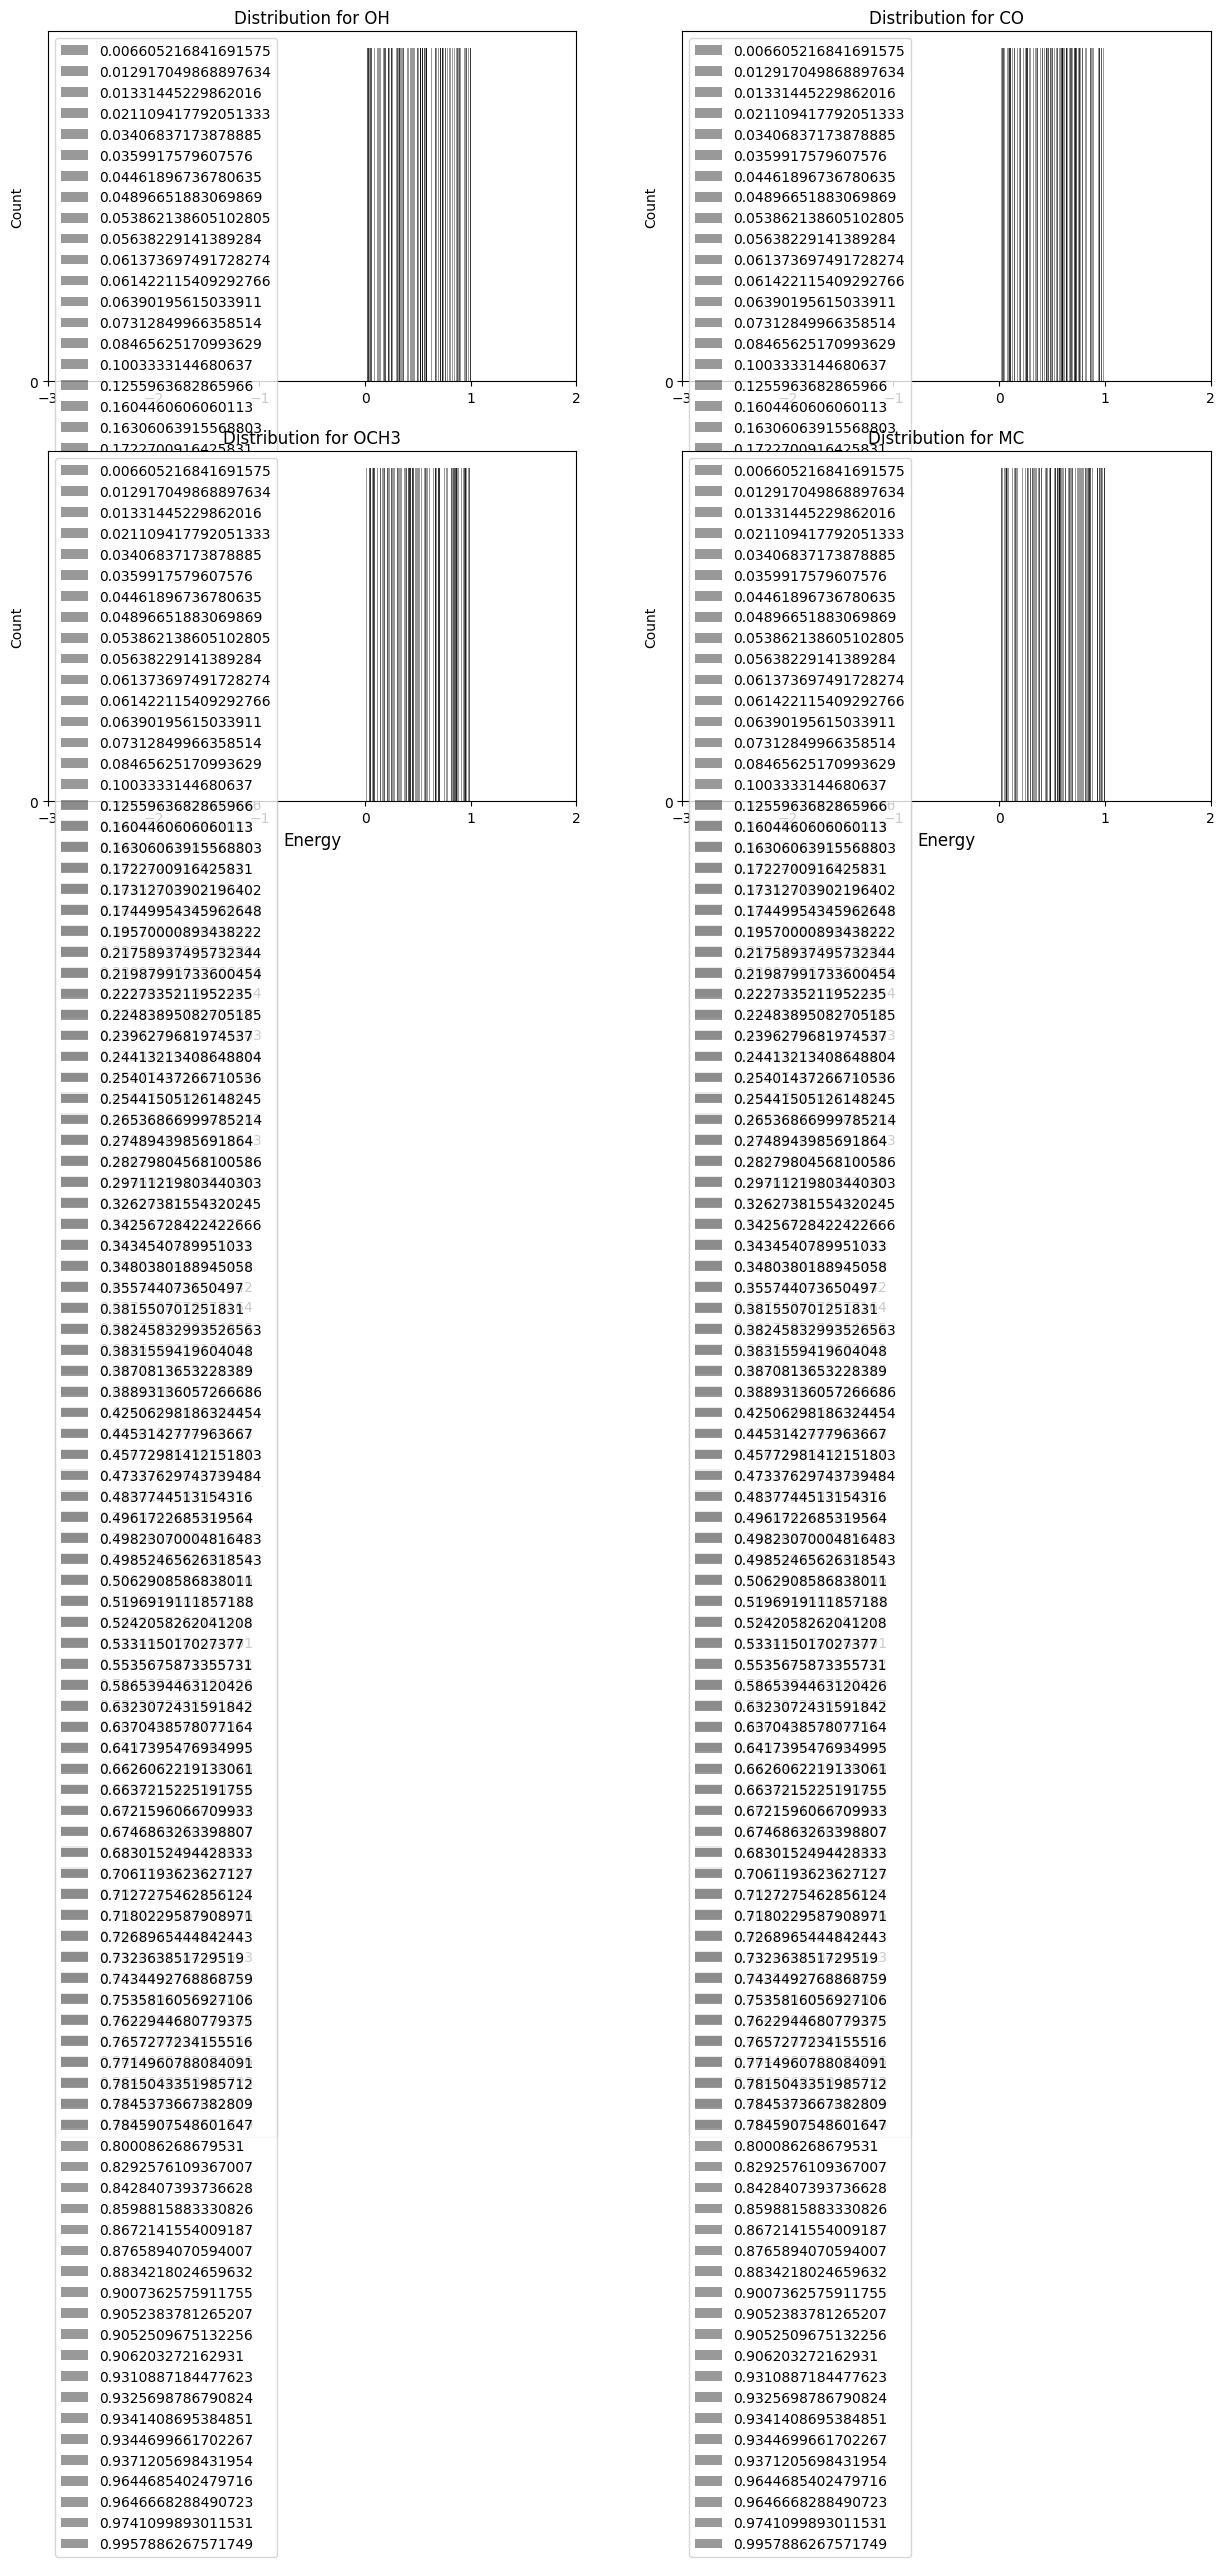

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data (for demonstration purposes, replace with your actual data)
surface = np.random.rand(10, 10, 3)  # Replace with actual surface data
E_OH = np.random.rand(100)  # Replace with actual energy data
E_CO = np.random.rand(100)  # Replace with actual energy data
E_OCH3 = np.random.rand(100)  # Replace with actual energy data
E_MC = np.random.rand(100)  # Replace with actual energy data
N = 100  # Replace with your actual value for N

# Get the unique metals in the surface
surface_metals = surface[:, :, 0].flatten()
metals = np.unique(surface_metals)

# Define colors for each metal
metal_colors = {
    'Ag': 'silver', 
    'Au': 'gold', 
    'Cu': 'darkorange', 
    'Pd': 'blue', 
    'Pt': 'green', 
    'Zn': 'purple'
}

# Create figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Define adsorbates and their respective energies
adsorbates = {
    "OH": E_OH,
    "CO": E_CO,
    "OCH3": E_OCH3,
    "MC": E_MC
}

# Manually define the titles for each plot
plot_titles = [
    'Distribution for OH',
    'Distribution for CO',
    'Distribution for OCH3',
    'Distribution for MC'
]

# Plot histograms for each adsorbate
for ax, (adsorbate, energies), title in zip(axs.flatten(), adsorbates.items(), plot_titles):
    for metal in metals:
        mask = surface_metals == metal
        color = metal_colors.get(metal, 'black')  # Default to black if the metal is not in the metal_colors dict
        ax.hist(energies[mask], bins=100, alpha=0.4, label=metal, histtype='stepfilled', color=color)
    ax.set_title(title)
    ax.set_ylabel('Count')
    ax.legend()
    ax.set_xlim(-3, 2)  # Centering the x-axis around 0
    ax.set_yticks(np.arange(0, ax.get_ylim()[1]+1, 50))  # Set y-axis tick marks every 50 units

axs[1, 0].set_xlabel('Energy', fontsize=12)
axs[1, 1].set_xlabel('Energy', fontsize=12)
plt.savefig(f'Densitysquare_of_bonding_N{N}.png')

plt.tight_layout(pad=0.5)
plt.show()


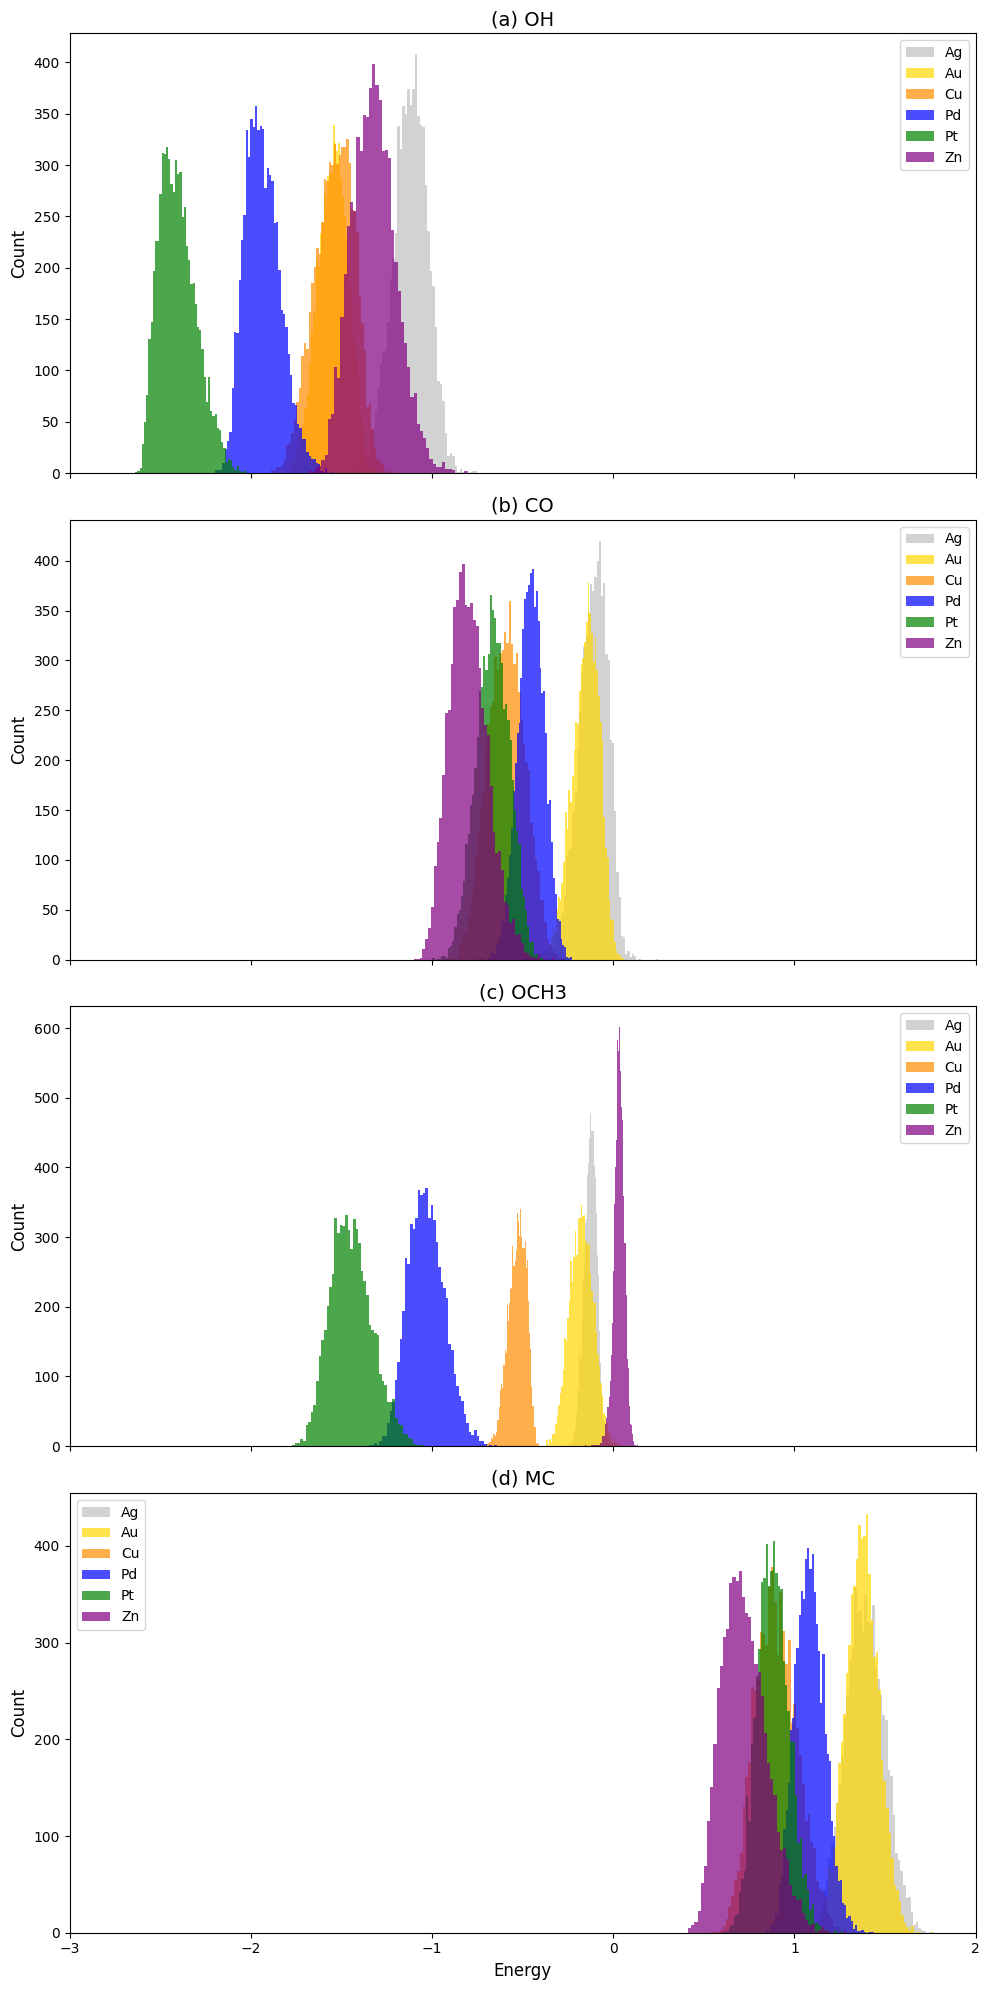

In [27]:
import matplotlib.ticker as ticker

# Get the unique metals in the surface
surface_metals = surface.surface[:, :, 0].flatten()
metals = np.unique(surface_metals)

# Define colors for each metal
metal_colors = {
    'Ag': 'silver', 
    'Au': 'gold', 
    'Cu': 'darkorange', 
    'Pd': 'blue', 
    'Pt': 'green', 
    'Zn': 'purple'
}

# Create figure and subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 20), sharex=True)

# Define adsorbates and their respective energies
adsorbates = {
    "OH": E_OH,
    "CO": E_CO,
    "OCH3": E_OCH3,
    "MC": E_MC
}

# Plot histograms for each adsorbate
for ax, (adsorbate, energies) in zip(axs, adsorbates.items()):
    for metal in metals:
        mask = surface_metals == metal
        color = metal_colors.get(metal, 'black')  # Default to black if the metal is not in the metal_colors dict
        ax.hist(energies[mask], bins=50, alpha=0.7, label=metal, histtype='stepfilled', color=color)
    ax.set_title(f'({chr(97 + list(adsorbates.keys()).index(adsorbate))}) {adsorbate}', fontsize=14)
    ax.set_ylabel('Count', fontsize=12)
    ax.legend()




# Centering the x-axis around 0
for ax in axs:
    ax.set_xlim(-3, 2)

axs[-1].set_xlabel('Energy', fontsize=12)
plt.tight_layout(pad=1.0) 
plt.savefig(f'Density_of_bonding_N{N}.png')
plt.tight_layout()
plt.show()

In [ ]:
surface = Surface_DMC(n=200)
surface.initiate_surface(np.ones(6)/6)
E_OCH3,E_MC,E_CO,E_OH,site_ids = surface.predict_energies()

surface_metals = surface.surface[:,:,0].flatten()
for metal in metals:
    mask = surface_metals == metal

    plt.hist(E_OH[mask],bins=100,label=metal)
plt.legend()

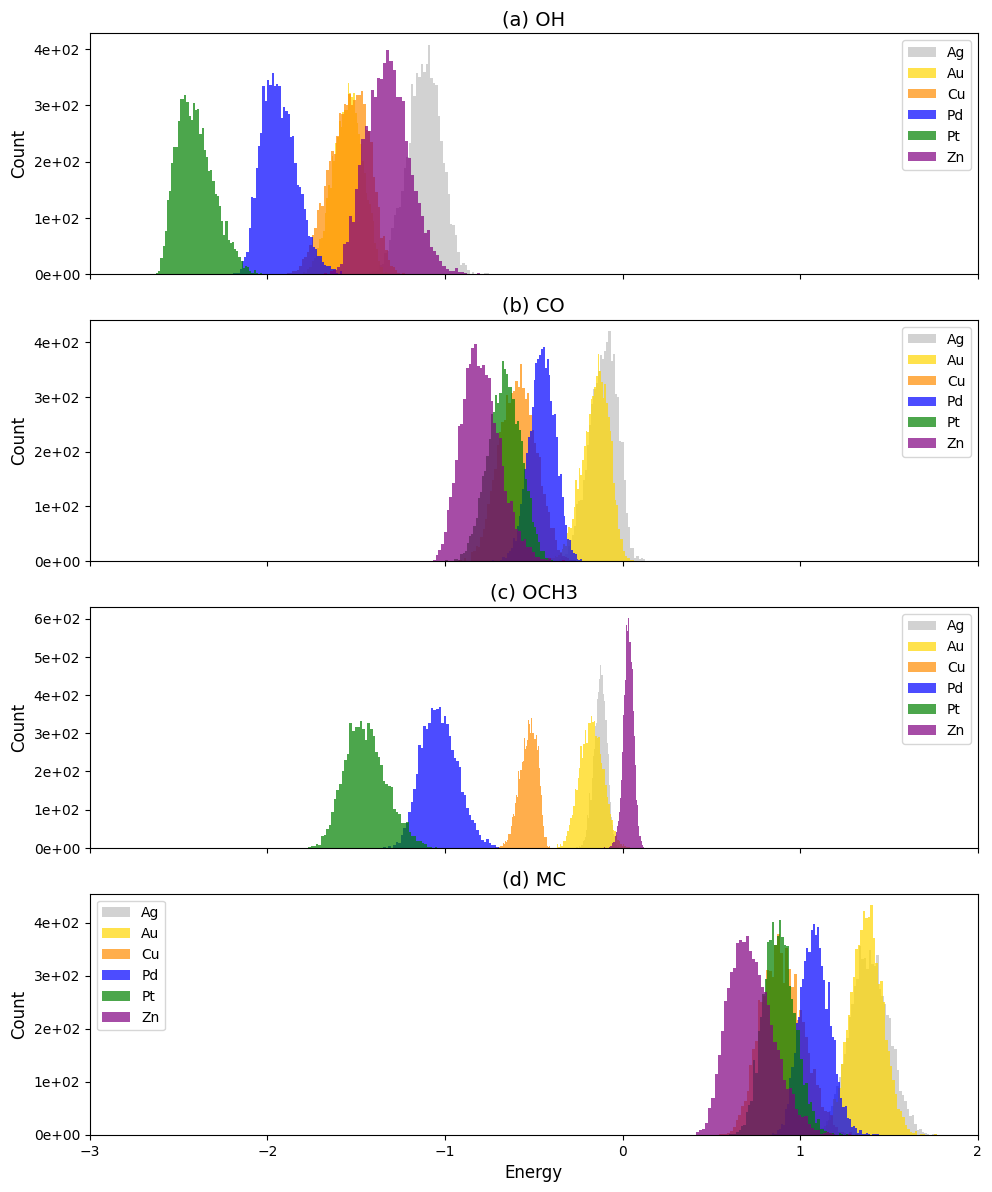

In [20]:

import matplotlib.ticker as ticker
# Get the unique metals in the surface
surface_metals = surface.surface[:, :, 0].flatten()
metals = np.unique(surface_metals)

# Define colors for each metal
metal_colors = {
    'Ag': 'silver', 
    'Au': 'gold', 
    'Cu': 'darkorange', 
    'Pd': 'blue', 
    'Pt': 'green', 
    'Zn': 'purple'
}

# Create figure and subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Define adsorbates and their respective energies
adsorbates = {
    "OH": E_OH,
    "CO": E_CO,
    "OCH3": E_OCH3,
    "MC": E_MC
}

# Plot histograms for each adsorbate
for ax, (adsorbate, energies) in zip(axs, adsorbates.items()):
    for metal in metals:
        mask = surface_metals == metal
        color = metal_colors.get(metal, 'black')  # Default to black if the metal is not in the metal_colors dict
        ax.hist(energies[mask], bins=50, alpha=0.7, label=metal, histtype='stepfilled', color=color)
    ax.set_title(f'({chr(97 + list(adsorbates.keys()).index(adsorbate))}) {adsorbate}', fontsize=14)
    ax.set_ylabel('Count', fontsize=12)
    ax.legend()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:.0e}'))  # Use scientific notation for y-axis

# Centering the x-axis around 0
for ax in axs:
    ax.set_xlim(-3, 2)

axs[-1].set_xlabel('Energy', fontsize=12)

plt.tight_layout(pad=1.0)  # Reduce the padding between plots
plt.show()